In [23]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize


In [24]:
# Parameters
num_qubits = 4
t1, t2, gate_time = 100e3, 100e3, 150


In [33]:
initial_states = []

for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)  # Flip one qubit to prepare |φ_k⟩
    initial_states.append(qc)


In [25]:
# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)
print(hamiltonian)


SparsePauliOp(['IIIX', 'IIXI', 'IXII', 'XIII', 'IIZZ', 'IZZI', 'ZZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


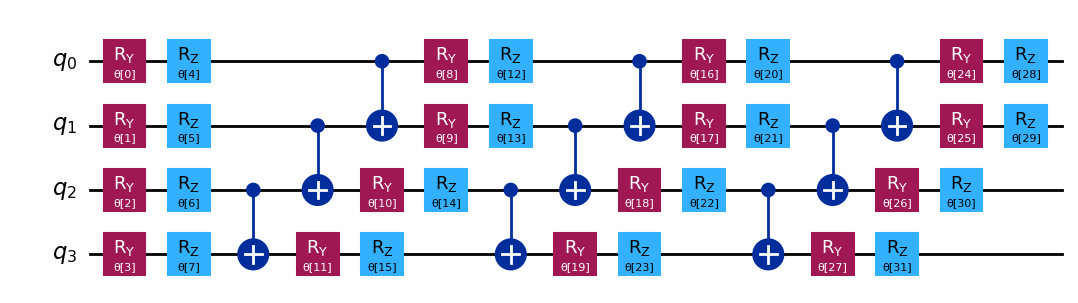

In [26]:
# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
ansatz.draw("mpl")

In [27]:
weights = np.arange(num_qubits, 0, -1)
print(weights)


[4 3 2 1]


In [28]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

t1, t2 = 80e-6, 60e-6
gt1, gt2 = 50e-9, 300e-9

noise_model = NoiseModel()
e1 = depolarizing_error(0.001, 1).compose(
         thermal_relaxation_error(t1, t2, gt1))
e2 = depolarizing_error(0.01, 2)
ro = ReadoutError([[0.95, 0.05], [0.05, 0.95]])

noise_model.add_all_qubit_quantum_error(e1, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(e2, ['cx'])
noise_model.add_all_qubit_readout_error(ro)


In [29]:

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}


In [30]:

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval


In [31]:

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy


In [34]:
# Optimization
init_params = np.random.rand(ansatz.num_parameters) * 2 *0.01* np.pi
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='BFGS',
    options={'maxiter': 500}
)



[Iter 1] Cost: 48.949951
[Iter 2] Cost: 48.940430
[Iter 3] Cost: 48.911133
[Iter 4] Cost: 48.880127
[Iter 5] Cost: 48.873779
[Iter 6] Cost: 48.954102
[Iter 7] Cost: 48.820312
[Iter 8] Cost: 48.888428
[Iter 9] Cost: 48.917480
[Iter 10] Cost: 48.860352
[Iter 11] Cost: 48.808105
[Iter 12] Cost: 48.947510
[Iter 13] Cost: 48.973389
[Iter 14] Cost: 48.917725
[Iter 15] Cost: 48.901611
[Iter 16] Cost: 48.941895
[Iter 17] Cost: 48.928955
[Iter 18] Cost: 49.031494
[Iter 19] Cost: 48.837402
[Iter 20] Cost: 48.986084
[Iter 21] Cost: 48.759033
[Iter 22] Cost: 48.909912
[Iter 23] Cost: 48.928223
[Iter 24] Cost: 49.034668
[Iter 25] Cost: 48.933594
[Iter 26] Cost: 48.886963
[Iter 27] Cost: 49.049805
[Iter 28] Cost: 48.810059
[Iter 29] Cost: 48.844238
[Iter 30] Cost: 48.825928
[Iter 31] Cost: 48.945312
[Iter 32] Cost: 49.018799
[Iter 33] Cost: 49.002441
[Iter 34] Cost: 48.106934
[Iter 35] Cost: 48.150391
[Iter 36] Cost: 48.113037
[Iter 37] Cost: 48.252197
[Iter 38] Cost: 48.093506
[Iter 39] Cost: 48.29

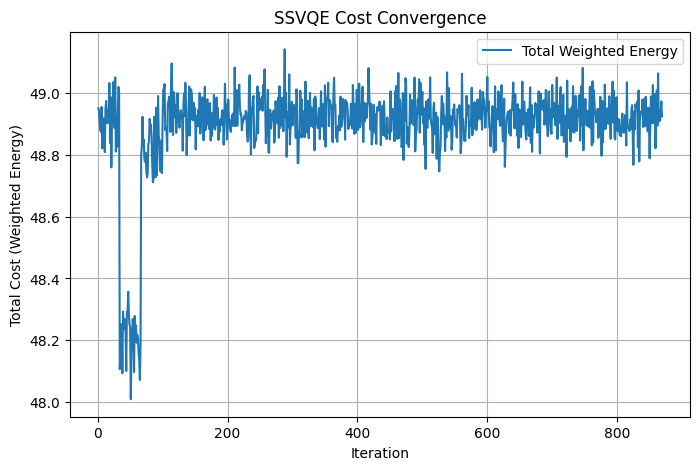

In [35]:
# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()


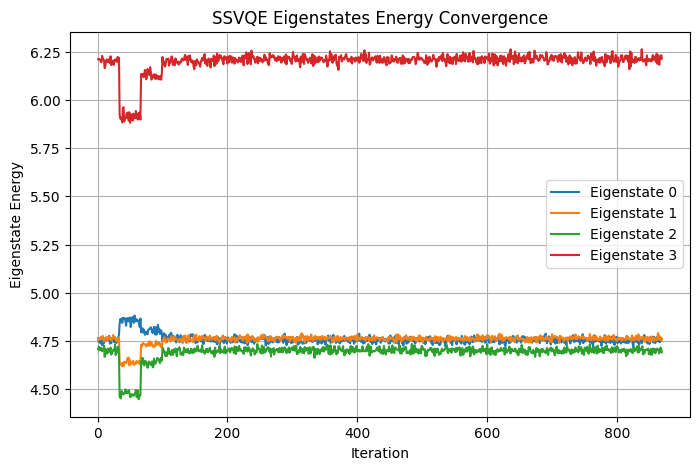

In [36]:

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 43.179443
[Iter 2] Cost: 43.048828
[Iter 3] Cost: 42.833252
[Iter 4] Cost: 41.690186
[Iter 5] Cost: 41.710693
[Iter 6] Cost: 41.285889
[Iter 7] Cost: 41.010010
[Iter 8] Cost: 40.845703
[Iter 9] Cost: 40.892822
[Iter 10] Cost: 39.845459
[Iter 11] Cost: 39.522705
[Iter 12] Cost: 39.476074
[Iter 13] Cost: 39.545654
[Iter 14] Cost: 39.267578
[Iter 15] Cost: 40.035645
[Iter 16] Cost: 39.035156
[Iter 17] Cost: 39.378174
[Iter 18] Cost: 39.535645
[Iter 19] Cost: 39.385498
[Iter 20] Cost: 38.862305
[Iter 21] Cost: 38.772217
[Iter 22] Cost: 39.056641
[Iter 23] Cost: 39.253174
[Iter 24] Cost: 39.008545
[Iter 25] Cost: 38.865479
[Iter 26] Cost: 38.851807
[Iter 27] Cost: 39.101318
[Iter 28] Cost: 39.335205
[Iter 29] Cost: 38.936279
[Iter 30] Cost: 38.905762
[Iter 31] Cost: 38.635010
[Iter 32] Cost: 38.916504
[Iter 33] Cost: 38.777344
[Iter 34] Cost: 38.207764
[Iter 35] Cost: 38.155273
[Iter 36] Cost: 38.826416
[Iter 37] Cost: 37.881836
[Iter 38] Cost: 38.053467
[Iter 39] Cost: 40.31

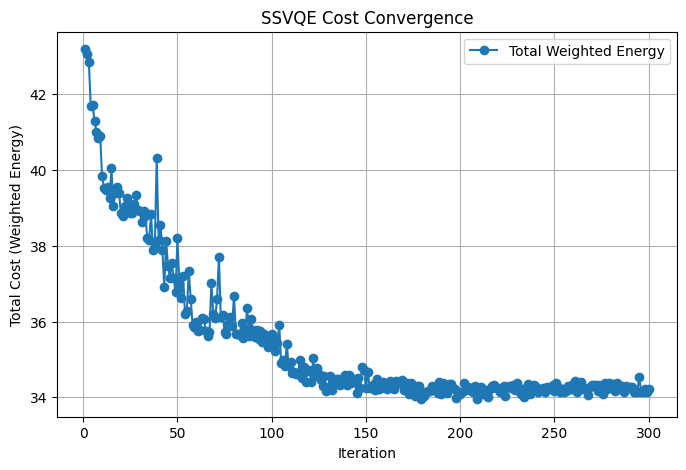

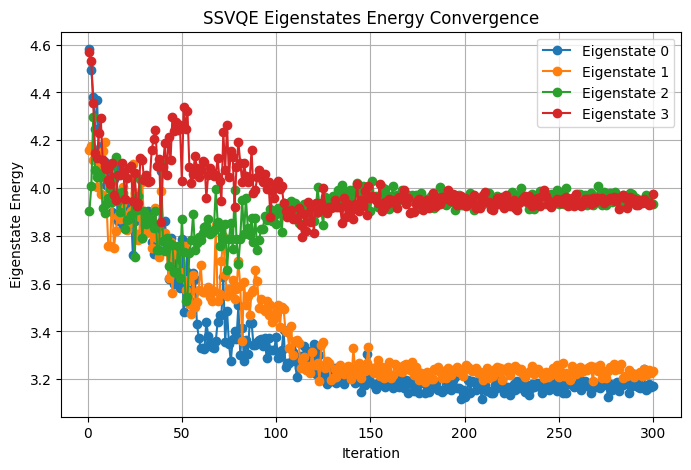

In [43]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 100e3, 100e3, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.05, 1).compose(thermal_relaxation_error(t1, t2, gate_time))
error_2q = depolarizing_error(0.01, 2)
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


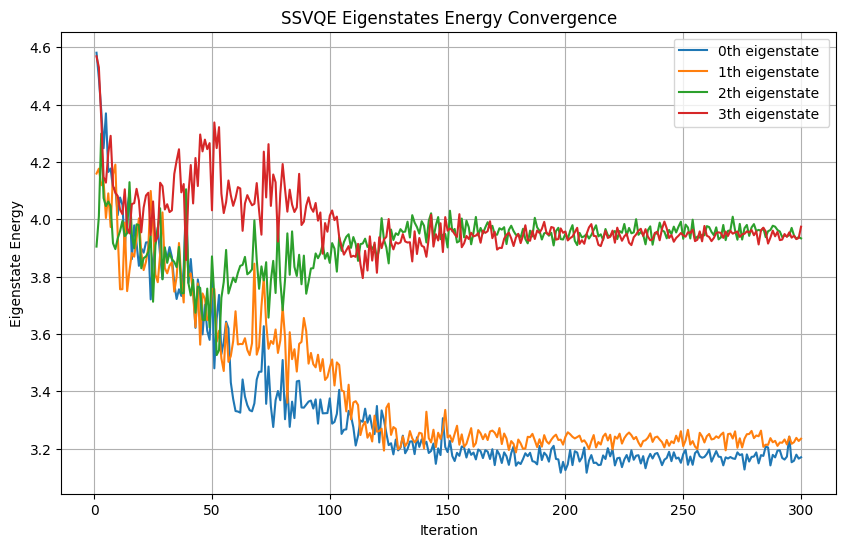

In [46]:
plt.figure(figsize=(10, 6))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"{i}th eigenstate ")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 42.133057
[Iter 2] Cost: 42.759766
[Iter 3] Cost: 40.684814
[Iter 4] Cost: 40.635010
[Iter 5] Cost: 40.979492
[Iter 6] Cost: 40.276367
[Iter 7] Cost: 40.437744
[Iter 8] Cost: 40.663086
[Iter 9] Cost: 39.745361
[Iter 10] Cost: 39.880859
[Iter 11] Cost: 39.394043
[Iter 12] Cost: 41.017334
[Iter 13] Cost: 39.688965
[Iter 14] Cost: 39.330078
[Iter 15] Cost: 39.509033
[Iter 16] Cost: 39.380615
[Iter 17] Cost: 39.499756
[Iter 18] Cost: 39.758057
[Iter 19] Cost: 39.399170
[Iter 20] Cost: 39.245605
[Iter 21] Cost: 39.575195
[Iter 22] Cost: 38.952148
[Iter 23] Cost: 38.610840
[Iter 24] Cost: 38.892578
[Iter 25] Cost: 39.949219
[Iter 26] Cost: 37.992432
[Iter 27] Cost: 38.169678
[Iter 28] Cost: 38.829834
[Iter 29] Cost: 38.320068
[Iter 30] Cost: 37.884766
[Iter 31] Cost: 38.079834
[Iter 32] Cost: 38.023193
[Iter 33] Cost: 38.124023
[Iter 34] Cost: 38.624756
[Iter 35] Cost: 38.125977
[Iter 36] Cost: 38.285645
[Iter 37] Cost: 38.206055
[Iter 38] Cost: 38.243164
[Iter 39] Cost: 38.10

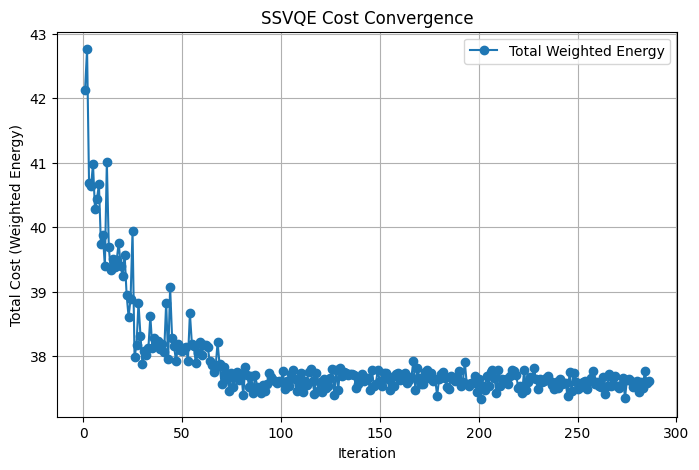

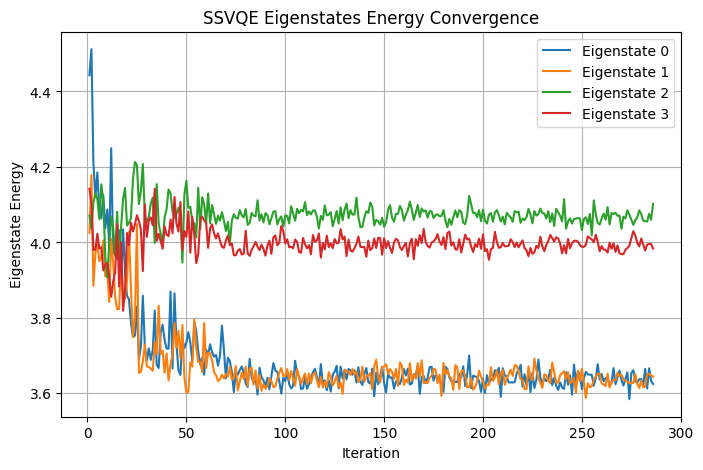

In [47]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 10e3, 10e3, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.05, 1).compose(thermal_relaxation_error(t1, t2, gate_time))
error_2q = depolarizing_error(0.01, 2)
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 42.467773
[Iter 2] Cost: 41.423584
[Iter 3] Cost: 41.358643
[Iter 4] Cost: 41.311279
[Iter 5] Cost: 41.210938
[Iter 6] Cost: 39.668701
[Iter 7] Cost: 39.817383
[Iter 8] Cost: 39.601318
[Iter 9] Cost: 39.826416
[Iter 10] Cost: 39.538086
[Iter 11] Cost: 39.610596
[Iter 12] Cost: 39.245361
[Iter 13] Cost: 39.328613
[Iter 14] Cost: 39.167969
[Iter 15] Cost: 39.593018
[Iter 16] Cost: 39.147705
[Iter 17] Cost: 39.517334
[Iter 18] Cost: 39.148926
[Iter 19] Cost: 39.266602
[Iter 20] Cost: 39.113037
[Iter 21] Cost: 39.393066
[Iter 22] Cost: 39.318848
[Iter 23] Cost: 39.139404
[Iter 24] Cost: 38.926270
[Iter 25] Cost: 38.738037
[Iter 26] Cost: 39.153809
[Iter 27] Cost: 39.876465
[Iter 28] Cost: 38.968018
[Iter 29] Cost: 39.024170
[Iter 30] Cost: 38.793213
[Iter 31] Cost: 38.667480
[Iter 32] Cost: 38.924316
[Iter 33] Cost: 38.889160
[Iter 34] Cost: 38.799805
[Iter 35] Cost: 38.688477
[Iter 36] Cost: 38.868896
[Iter 37] Cost: 39.069580
[Iter 38] Cost: 39.389648
[Iter 39] Cost: 38.79

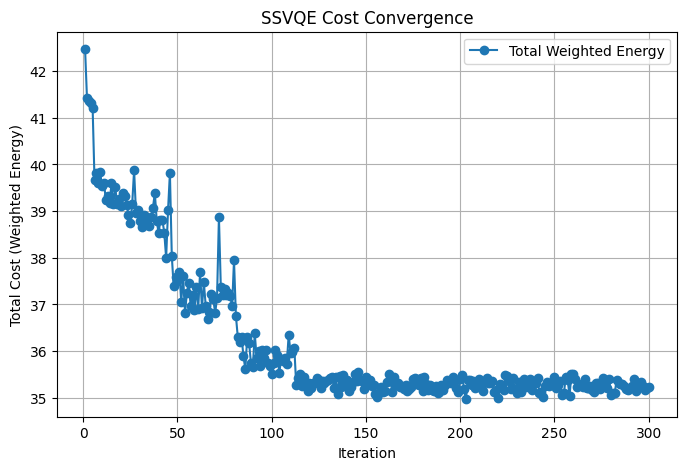

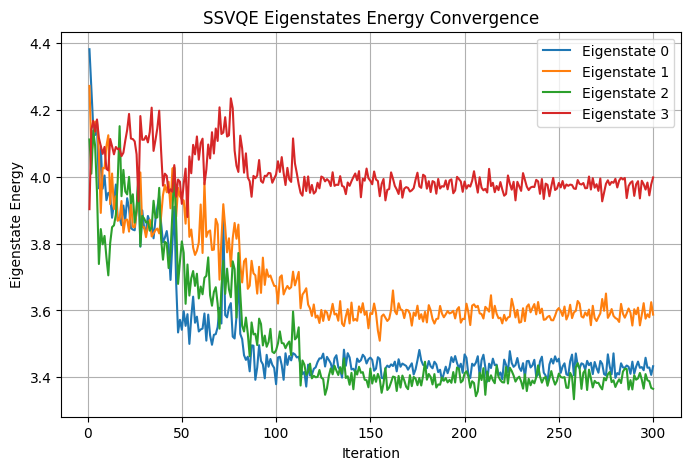

In [48]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 5e3, 10e3, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.05, 1).compose(thermal_relaxation_error(t1, t2, gate_time))
error_2q = depolarizing_error(0.01, 2)
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 42.562988
[Iter 2] Cost: 42.311035
[Iter 3] Cost: 41.343994
[Iter 4] Cost: 40.999023
[Iter 5] Cost: 40.888672
[Iter 6] Cost: 40.079102
[Iter 7] Cost: 39.776367
[Iter 8] Cost: 39.952637
[Iter 9] Cost: 40.328369
[Iter 10] Cost: 39.237305
[Iter 11] Cost: 40.350830
[Iter 12] Cost: 39.549316
[Iter 13] Cost: 39.025391
[Iter 14] Cost: 38.842041
[Iter 15] Cost: 39.255615
[Iter 16] Cost: 38.623291
[Iter 17] Cost: 38.984131
[Iter 18] Cost: 38.588867
[Iter 19] Cost: 39.183594
[Iter 20] Cost: 38.872070
[Iter 21] Cost: 38.435303
[Iter 22] Cost: 38.325439
[Iter 23] Cost: 38.986328
[Iter 24] Cost: 38.355713
[Iter 25] Cost: 38.824951
[Iter 26] Cost: 38.543213
[Iter 27] Cost: 38.871582
[Iter 28] Cost: 39.327881
[Iter 29] Cost: 38.502686
[Iter 30] Cost: 38.545898
[Iter 31] Cost: 38.421875
[Iter 32] Cost: 38.252197
[Iter 33] Cost: 38.387207
[Iter 34] Cost: 38.641846
[Iter 35] Cost: 38.768311
[Iter 36] Cost: 39.150879
[Iter 37] Cost: 38.683105
[Iter 38] Cost: 38.111572
[Iter 39] Cost: 38.24

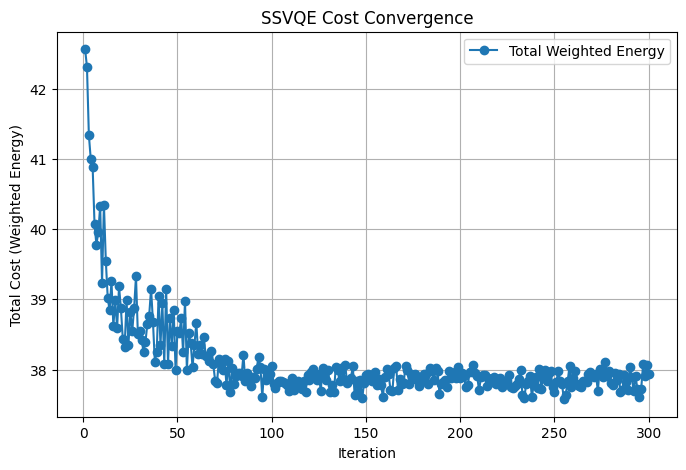

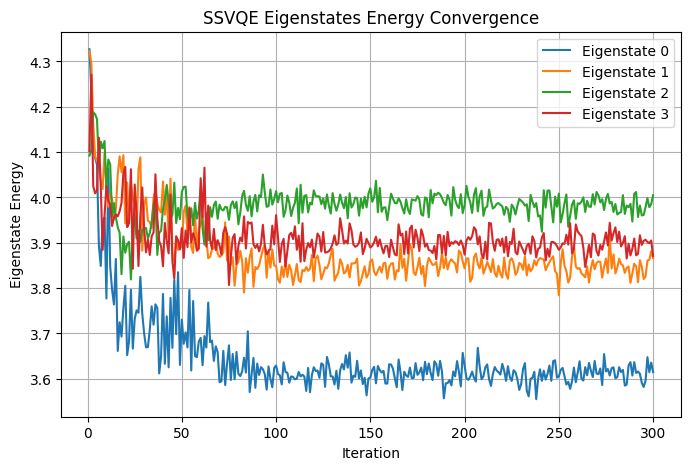

In [52]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 2e3, 4e3, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.05, 1).compose(thermal_relaxation_error(t1, t2, gate_time))
error_2q = depolarizing_error(0.01, 2)
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 41.110840
[Iter 2] Cost: 41.053711
[Iter 3] Cost: 40.556641
[Iter 4] Cost: 40.738525
[Iter 5] Cost: 40.740967
[Iter 6] Cost: 40.618896
[Iter 7] Cost: 40.667969
[Iter 8] Cost: 40.640625
[Iter 9] Cost: 40.750000
[Iter 10] Cost: 40.646484
[Iter 11] Cost: 40.871826
[Iter 12] Cost: 40.656250
[Iter 13] Cost: 40.787842
[Iter 14] Cost: 40.645264
[Iter 15] Cost: 40.541992
[Iter 16] Cost: 40.659912
[Iter 17] Cost: 40.739014
[Iter 18] Cost: 40.669189
[Iter 19] Cost: 40.619141
[Iter 20] Cost: 40.509033
[Iter 21] Cost: 40.558350
[Iter 22] Cost: 40.530029
[Iter 23] Cost: 40.633057
[Iter 24] Cost: 40.524170
[Iter 25] Cost: 40.719482
[Iter 26] Cost: 40.247803
[Iter 27] Cost: 40.346191
[Iter 28] Cost: 40.322998
[Iter 29] Cost: 40.309082
[Iter 30] Cost: 40.200439
[Iter 31] Cost: 40.263428
[Iter 32] Cost: 40.162109
[Iter 33] Cost: 40.191895
[Iter 34] Cost: 40.165771
[Iter 35] Cost: 40.382080
[Iter 36] Cost: 40.170898
[Iter 37] Cost: 40.278809
[Iter 38] Cost: 40.196289
[Iter 39] Cost: 40.45

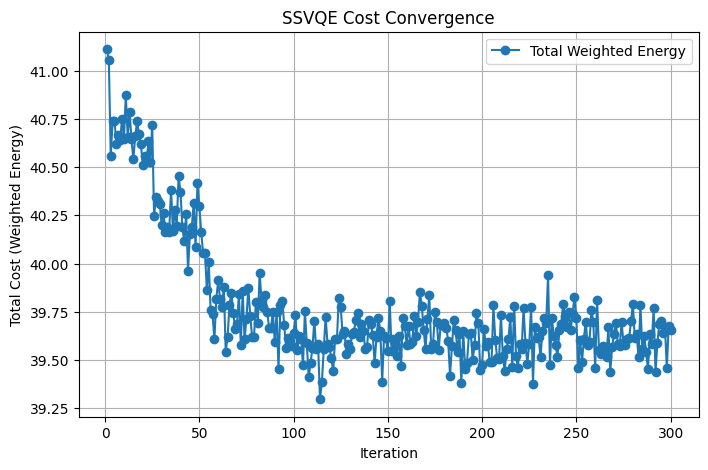

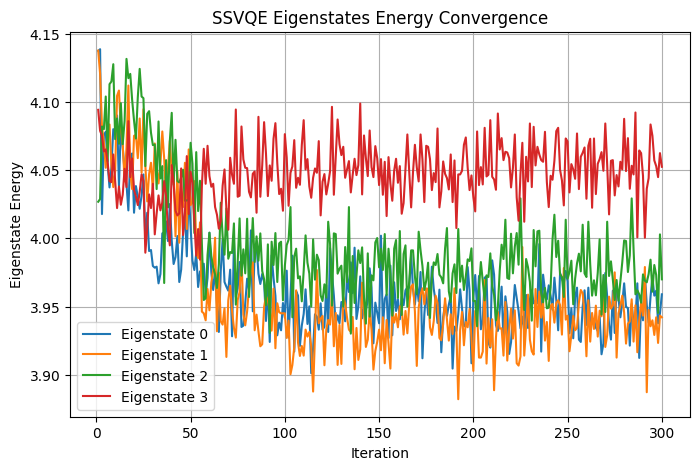

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 2e3, 4e3, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.15, 1).compose(thermal_relaxation_error(t1, t2, gate_time))
error_2q = depolarizing_error(0.1, 2)
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 41.428223
[Iter 2] Cost: 41.384521
[Iter 3] Cost: 41.243652
[Iter 4] Cost: 41.434082
[Iter 5] Cost: 41.172607
[Iter 6] Cost: 40.720703
[Iter 7] Cost: 40.786133
[Iter 8] Cost: 40.931152
[Iter 9] Cost: 40.976318
[Iter 10] Cost: 40.705322
[Iter 11] Cost: 41.036865
[Iter 12] Cost: 40.599609
[Iter 13] Cost: 40.493896
[Iter 14] Cost: 40.598633
[Iter 15] Cost: 40.587402
[Iter 16] Cost: 40.772217
[Iter 17] Cost: 40.513428
[Iter 18] Cost: 40.594727
[Iter 19] Cost: 40.325439
[Iter 20] Cost: 40.462402
[Iter 21] Cost: 40.276855
[Iter 22] Cost: 40.355225
[Iter 23] Cost: 40.491455
[Iter 24] Cost: 40.545898
[Iter 25] Cost: 40.690186
[Iter 26] Cost: 40.140869
[Iter 27] Cost: 40.441895
[Iter 28] Cost: 40.302002
[Iter 29] Cost: 40.270752
[Iter 30] Cost: 39.976318
[Iter 31] Cost: 40.183350
[Iter 32] Cost: 40.309570
[Iter 33] Cost: 40.210205
[Iter 34] Cost: 39.960693
[Iter 35] Cost: 40.250488
[Iter 36] Cost: 40.197998
[Iter 37] Cost: 40.188477
[Iter 38] Cost: 40.059082
[Iter 39] Cost: 40.13

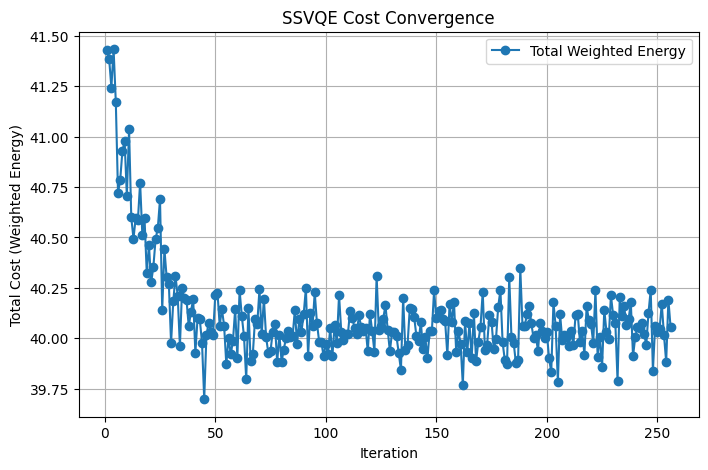

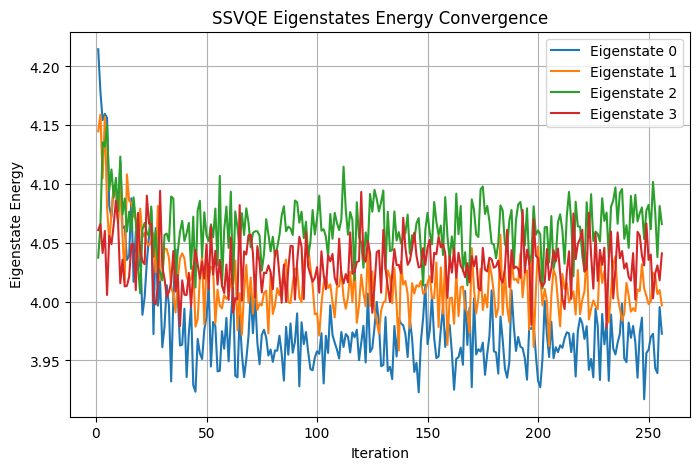

In [57]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 10e3, 10e3, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.15, 1).compose(thermal_relaxation_error(t1, t2, gate_time))
error_2q = depolarizing_error(0.05, 2)
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 41.303711
[Iter 2] Cost: 41.099365
[Iter 3] Cost: 40.631592
[Iter 4] Cost: 40.693848
[Iter 5] Cost: 40.756836
[Iter 6] Cost: 40.607910
[Iter 7] Cost: 40.605957
[Iter 8] Cost: 40.368896
[Iter 9] Cost: 40.400391
[Iter 10] Cost: 40.163818
[Iter 11] Cost: 39.749512
[Iter 12] Cost: 39.861328
[Iter 13] Cost: 39.725830
[Iter 14] Cost: 39.709473
[Iter 15] Cost: 39.764404
[Iter 16] Cost: 39.629150
[Iter 17] Cost: 39.714111
[Iter 18] Cost: 39.719482
[Iter 19] Cost: 39.690674
[Iter 20] Cost: 39.637939
[Iter 21] Cost: 39.592529
[Iter 22] Cost: 39.355713
[Iter 23] Cost: 39.655762
[Iter 24] Cost: 39.682617
[Iter 25] Cost: 39.551025
[Iter 26] Cost: 39.674316
[Iter 27] Cost: 39.753906
[Iter 28] Cost: 39.520508
[Iter 29] Cost: 39.588623
[Iter 30] Cost: 39.513916
[Iter 31] Cost: 39.689209
[Iter 32] Cost: 39.734131
[Iter 33] Cost: 39.641602
[Iter 34] Cost: 39.596191
[Iter 35] Cost: 39.446777
[Iter 36] Cost: 39.181641
[Iter 37] Cost: 39.106201
[Iter 38] Cost: 39.596191
[Iter 39] Cost: 38.85

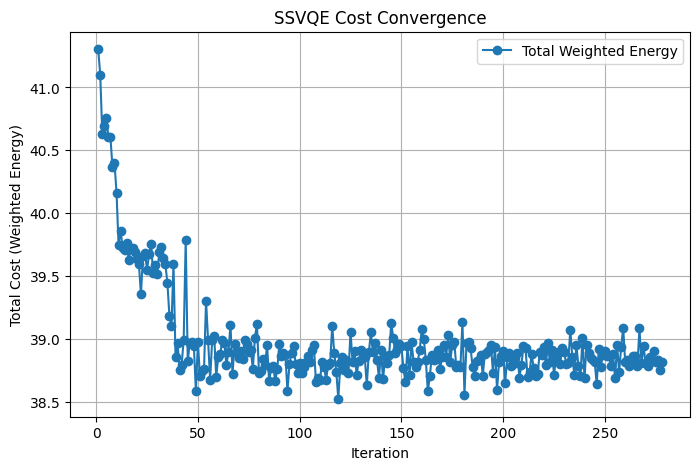

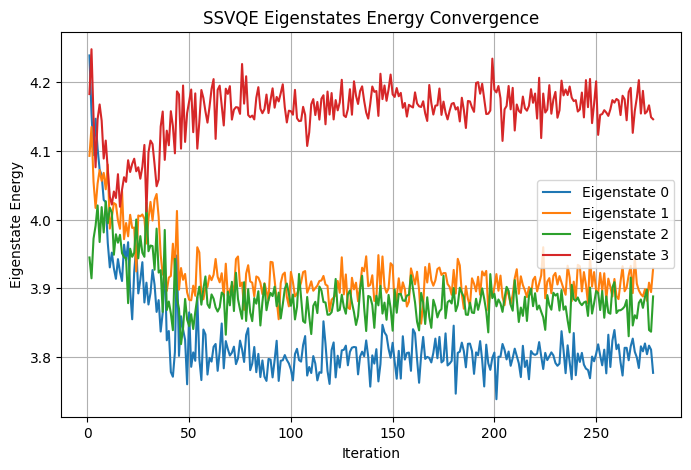

In [60]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 5e3, 5e3, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.13, 1).compose(thermal_relaxation_error(t1, t2, gate_time))
error_2q = depolarizing_error(0.05, 2)
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 44.185059
[Iter 2] Cost: 44.156006
[Iter 3] Cost: 43.250732
[Iter 4] Cost: 43.322266
[Iter 5] Cost: 43.193848
[Iter 6] Cost: 42.839600
[Iter 7] Cost: 42.211182
[Iter 8] Cost: 42.462402
[Iter 9] Cost: 42.625000
[Iter 10] Cost: 41.092773
[Iter 11] Cost: 40.891602
[Iter 12] Cost: 41.034668
[Iter 13] Cost: 41.237061
[Iter 14] Cost: 40.995850
[Iter 15] Cost: 40.883789
[Iter 16] Cost: 40.555176
[Iter 17] Cost: 40.677246
[Iter 18] Cost: 40.508789
[Iter 19] Cost: 40.804688
[Iter 20] Cost: 40.916992
[Iter 21] Cost: 40.773193
[Iter 22] Cost: 40.842285
[Iter 23] Cost: 40.859619
[Iter 24] Cost: 40.961426
[Iter 25] Cost: 41.177490
[Iter 26] Cost: 40.732422
[Iter 27] Cost: 40.033936
[Iter 28] Cost: 39.820068
[Iter 29] Cost: 40.507080
[Iter 30] Cost: 40.156494
[Iter 31] Cost: 39.818848
[Iter 32] Cost: 39.929199
[Iter 33] Cost: 40.033936
[Iter 34] Cost: 39.597656
[Iter 35] Cost: 39.927002
[Iter 36] Cost: 39.720947
[Iter 37] Cost: 39.429199
[Iter 38] Cost: 40.260498
[Iter 39] Cost: 39.89

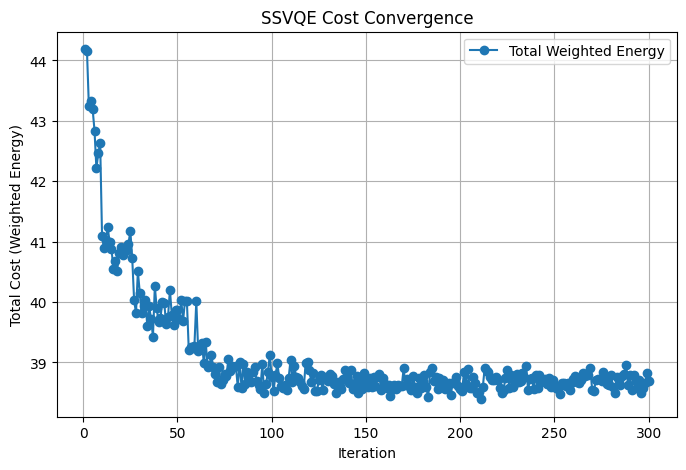

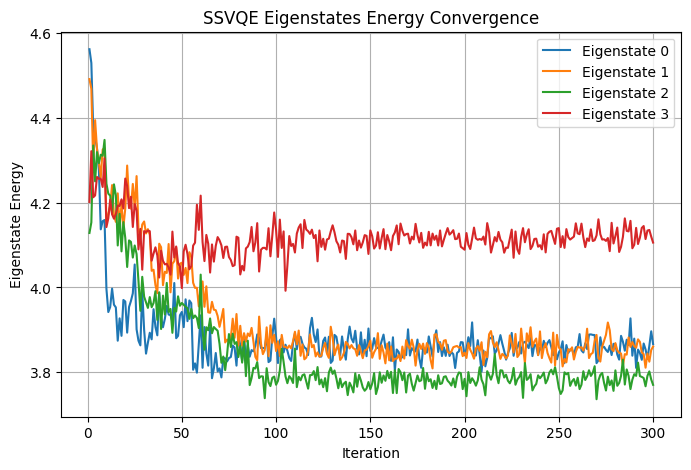

In [61]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 1000, 2000, 150  # coherence time 줄임

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.04, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time)
)
error_2q = depolarizing_error(0.05, 2)  # 약간 강화된 2Q 노이즈

readout_error = ReadoutError([[0.95, 0.05], [0.05, 0.95]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 43.481689
[Iter 2] Cost: 43.522461
[Iter 3] Cost: 43.119385
[Iter 4] Cost: 43.159424
[Iter 5] Cost: 42.872314
[Iter 6] Cost: 42.914062
[Iter 7] Cost: 42.882324
[Iter 8] Cost: 42.946045
[Iter 9] Cost: 42.880859
[Iter 10] Cost: 42.199463
[Iter 11] Cost: 42.120605
[Iter 12] Cost: 42.416260
[Iter 13] Cost: 42.191895
[Iter 14] Cost: 42.007324
[Iter 15] Cost: 41.996826
[Iter 16] Cost: 41.885254
[Iter 17] Cost: 42.046875
[Iter 18] Cost: 42.017578
[Iter 19] Cost: 41.653564
[Iter 20] Cost: 41.914062
[Iter 21] Cost: 41.983643
[Iter 22] Cost: 41.775146
[Iter 23] Cost: 41.894043
[Iter 24] Cost: 41.949219
[Iter 25] Cost: 41.818604
[Iter 26] Cost: 41.153564
[Iter 27] Cost: 40.710449
[Iter 28] Cost: 40.615723
[Iter 29] Cost: 40.734131
[Iter 30] Cost: 40.741211
[Iter 31] Cost: 40.832520
[Iter 32] Cost: 40.710693
[Iter 33] Cost: 40.701904
[Iter 34] Cost: 40.082031
[Iter 35] Cost: 40.525146
[Iter 36] Cost: 39.866943
[Iter 37] Cost: 40.108154
[Iter 38] Cost: 40.112793
[Iter 39] Cost: 39.81

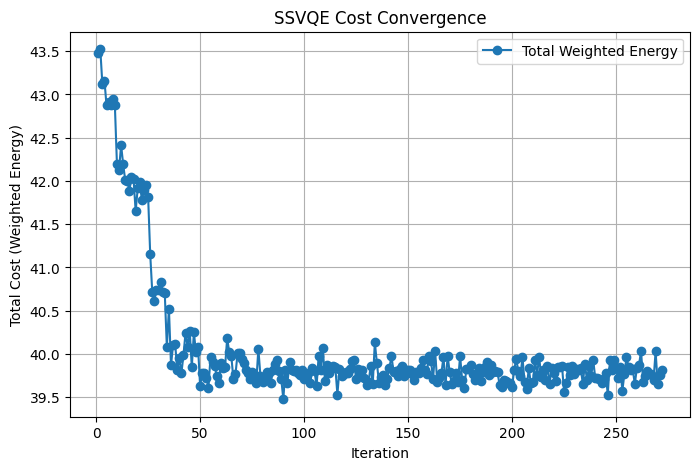

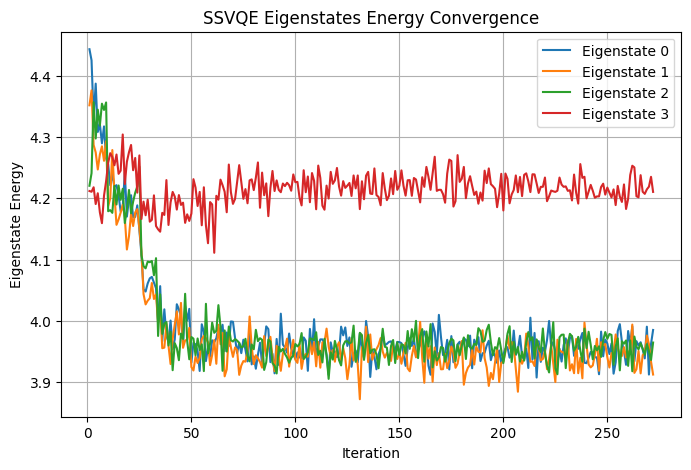

In [62]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 800, 1600, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.08, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time)
)
error_2q = depolarizing_error(0.12, 2)

# 리드아웃 오류 최소화 (TREX를 쓸 수 있게)
readout_error = ReadoutError([[0.99, 0.01], [0.01, 0.99]])

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 42.568359
[Iter 2] Cost: 42.387207
[Iter 3] Cost: 42.301514
[Iter 4] Cost: 42.219727
[Iter 5] Cost: 42.165527
[Iter 6] Cost: 41.836182
[Iter 7] Cost: 41.579102
[Iter 8] Cost: 41.864990
[Iter 9] Cost: 41.953369
[Iter 10] Cost: 41.420654
[Iter 11] Cost: 41.411621
[Iter 12] Cost: 41.461182
[Iter 13] Cost: 41.337646
[Iter 14] Cost: 41.229980
[Iter 15] Cost: 41.442383
[Iter 16] Cost: 41.025146
[Iter 17] Cost: 41.260986
[Iter 18] Cost: 41.046631
[Iter 19] Cost: 41.239258
[Iter 20] Cost: 41.256836
[Iter 21] Cost: 41.249512
[Iter 22] Cost: 41.313965
[Iter 23] Cost: 41.233887
[Iter 24] Cost: 41.239746
[Iter 25] Cost: 41.387939
[Iter 26] Cost: 40.778809
[Iter 27] Cost: 41.071777
[Iter 28] Cost: 40.809570
[Iter 29] Cost: 41.022705
[Iter 30] Cost: 40.735840
[Iter 31] Cost: 40.892578
[Iter 32] Cost: 40.837646
[Iter 33] Cost: 40.789795
[Iter 34] Cost: 40.719482
[Iter 35] Cost: 40.607666
[Iter 36] Cost: 40.494629
[Iter 37] Cost: 40.596680
[Iter 38] Cost: 40.532715
[Iter 39] Cost: 40.53

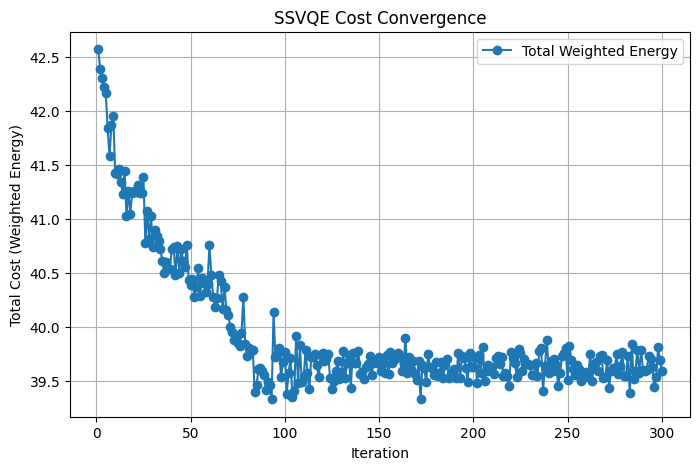

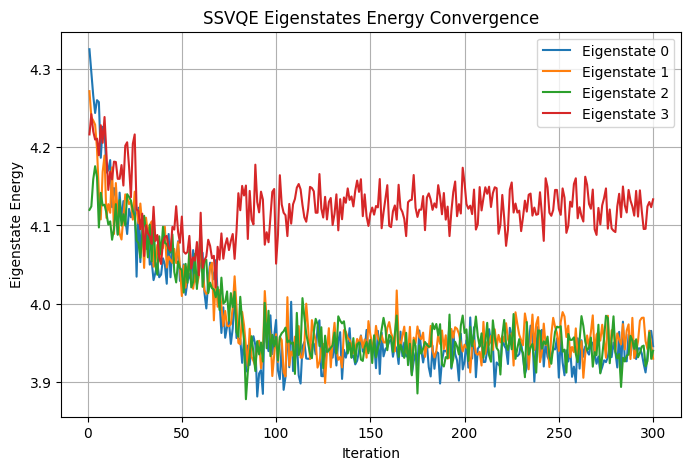

In [63]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 1000, 1000, 150

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.12, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time)
)

error_2q = depolarizing_error(0.15, 2)  # 더욱 공격적인 2-qubit noise

noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 300}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 42.398926
[Iter 2] Cost: 42.127441
[Iter 3] Cost: 41.955811
[Iter 4] Cost: 41.956543
[Iter 5] Cost: 42.010010
[Iter 6] Cost: 41.870361
[Iter 7] Cost: 41.784912
[Iter 8] Cost: 41.682617
[Iter 9] Cost: 41.714111
[Iter 10] Cost: 41.633789
[Iter 11] Cost: 41.554688
[Iter 12] Cost: 41.522949
[Iter 13] Cost: 41.651855
[Iter 14] Cost: 41.641113
[Iter 15] Cost: 41.595703
[Iter 16] Cost: 41.594971
[Iter 17] Cost: 41.608398
[Iter 18] Cost: 41.696045
[Iter 19] Cost: 41.583008
[Iter 20] Cost: 41.458496
[Iter 21] Cost: 41.480225
[Iter 22] Cost: 41.672119
[Iter 23] Cost: 41.641846
[Iter 24] Cost: 41.443848
[Iter 25] Cost: 41.603271
[Iter 26] Cost: 41.325684
[Iter 27] Cost: 40.911133
[Iter 28] Cost: 40.886230
[Iter 29] Cost: 40.824951
[Iter 30] Cost: 40.679688
[Iter 31] Cost: 40.654541
[Iter 32] Cost: 40.801270
[Iter 33] Cost: 40.989502
[Iter 34] Cost: 40.642334
[Iter 35] Cost: 40.691406
[Iter 36] Cost: 40.726807
[Iter 37] Cost: 40.645264
[Iter 38] Cost: 40.886963
[Iter 39] Cost: 40.80

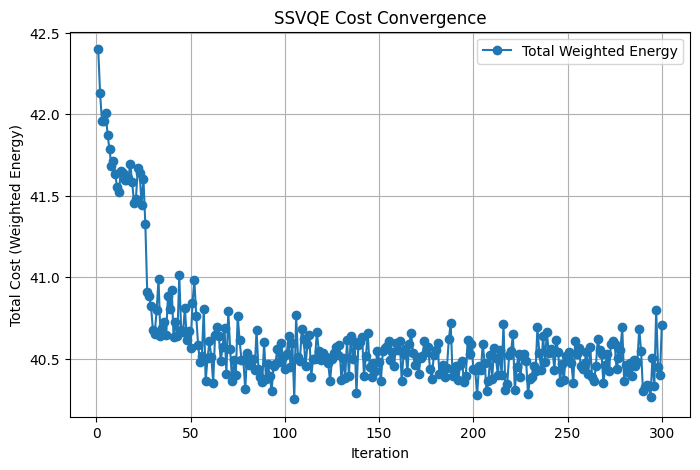

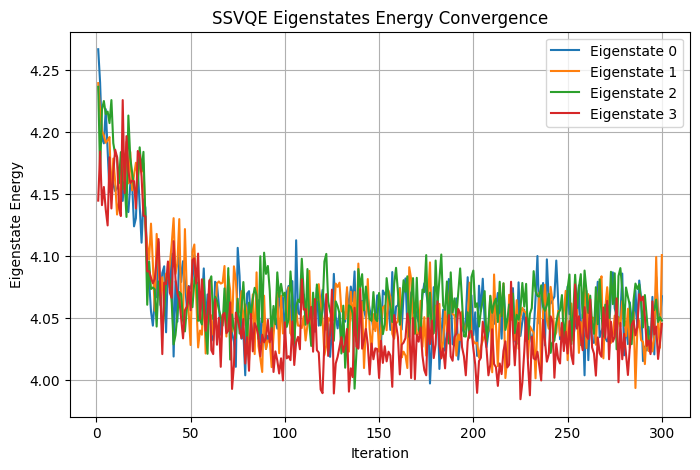

In [83]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 800, 1500, 150  # T2를 더 짧게

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.15, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time)
)
error_2q = depolarizing_error(0.20, 2)  # 매우 강하게 설정


noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 400}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 44.404297
[Iter 2] Cost: 44.180176
[Iter 3] Cost: 43.722900
[Iter 4] Cost: 43.548828
[Iter 5] Cost: 43.553467
[Iter 6] Cost: 43.522949
[Iter 7] Cost: 43.470215
[Iter 8] Cost: 43.369873
[Iter 9] Cost: 43.394531
[Iter 10] Cost: 42.578857
[Iter 11] Cost: 41.478516
[Iter 12] Cost: 40.452148
[Iter 13] Cost: 40.707031
[Iter 14] Cost: 40.508301
[Iter 15] Cost: 40.457520
[Iter 16] Cost: 40.402100
[Iter 17] Cost: 40.396484
[Iter 18] Cost: 40.186768
[Iter 19] Cost: 40.264893
[Iter 20] Cost: 40.003662
[Iter 21] Cost: 39.962158
[Iter 22] Cost: 39.982178
[Iter 23] Cost: 40.965332
[Iter 24] Cost: 40.035645
[Iter 25] Cost: 39.903564
[Iter 26] Cost: 39.836670
[Iter 27] Cost: 39.347412
[Iter 28] Cost: 39.007324
[Iter 29] Cost: 38.959961
[Iter 30] Cost: 38.990723
[Iter 31] Cost: 39.285156
[Iter 32] Cost: 38.900879
[Iter 33] Cost: 39.414062
[Iter 34] Cost: 38.939697
[Iter 35] Cost: 38.335938
[Iter 36] Cost: 38.056885
[Iter 37] Cost: 38.302002
[Iter 38] Cost: 38.415039
[Iter 39] Cost: 38.22

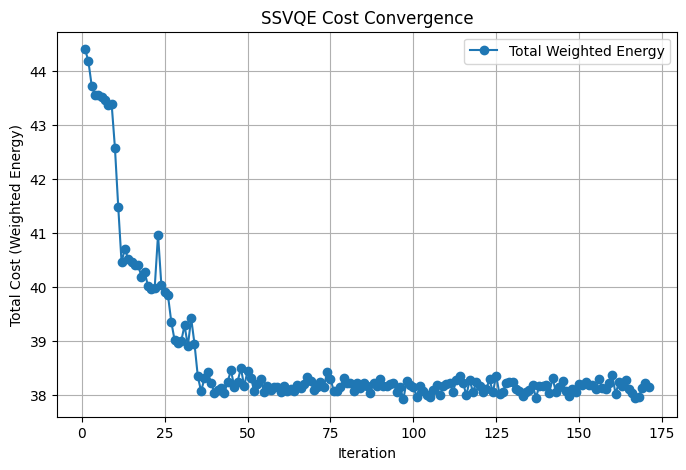

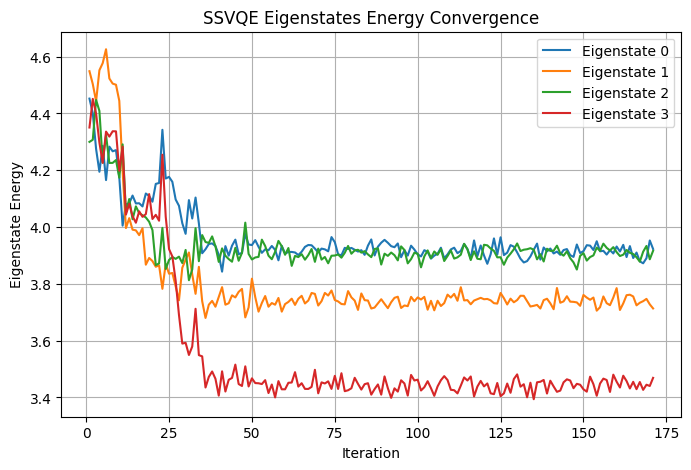

In [77]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 700, 1400, 150  # coherence time을 더 짧게

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear').decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.15, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time)
)
error_2q = depolarizing_error(0.20, 2)  # 매우 강하게 설정


noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 400}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 43.139893
[Iter 2] Cost: 42.791016
[Iter 3] Cost: 42.385010
[Iter 4] Cost: 42.447510
[Iter 5] Cost: 42.342773
[Iter 6] Cost: 41.807617
[Iter 7] Cost: 41.819336
[Iter 8] Cost: 41.943359
[Iter 9] Cost: 41.941162
[Iter 10] Cost: 41.572754
[Iter 11] Cost: 42.221191
[Iter 12] Cost: 41.715576
[Iter 13] Cost: 41.801514
[Iter 14] Cost: 41.573975
[Iter 15] Cost: 41.953369
[Iter 16] Cost: 41.507080
[Iter 17] Cost: 41.748291
[Iter 18] Cost: 41.298584
[Iter 19] Cost: 41.260254
[Iter 20] Cost: 41.169678
[Iter 21] Cost: 40.949707
[Iter 22] Cost: 41.072510
[Iter 23] Cost: 41.088623
[Iter 24] Cost: 41.091064
[Iter 25] Cost: 41.187744
[Iter 26] Cost: 40.729004
[Iter 27] Cost: 41.126465
[Iter 28] Cost: 40.800781
[Iter 29] Cost: 40.826660
[Iter 30] Cost: 40.607178
[Iter 31] Cost: 40.746338
[Iter 32] Cost: 40.497803
[Iter 33] Cost: 40.775635
[Iter 34] Cost: 40.136719
[Iter 35] Cost: 40.316406
[Iter 36] Cost: 40.149902
[Iter 37] Cost: 40.092285
[Iter 38] Cost: 40.243164
[Iter 39] Cost: 39.99

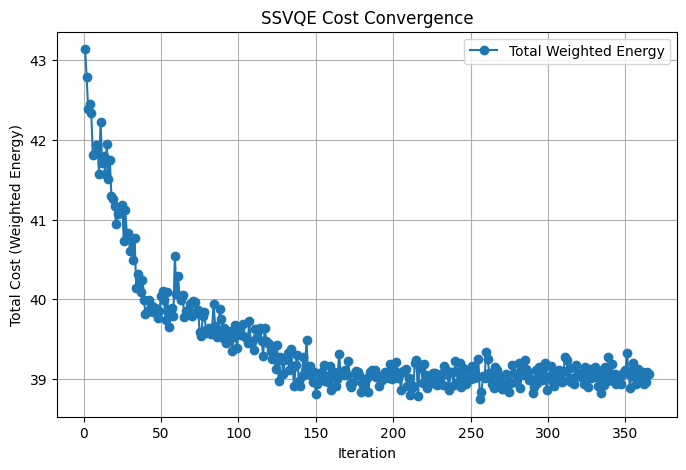

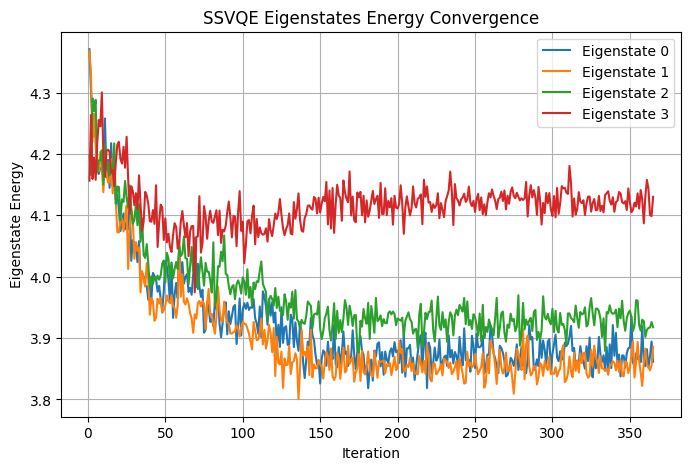

In [73]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 800, 1500, 150  # T2를 더 짧게

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits).decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.10, 1).compose(
    thermal_relaxation_error(1000, 2000, 150)
)
error_2q = depolarizing_error(0.12, 2)  # 20% → 12%로 줄임


noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 400}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 46.151855
[Iter 2] Cost: 45.317139
[Iter 3] Cost: 43.519775
[Iter 4] Cost: 42.442383
[Iter 5] Cost: 42.032959
[Iter 6] Cost: 42.201416
[Iter 7] Cost: 42.004150
[Iter 8] Cost: 42.138916
[Iter 9] Cost: 42.258545
[Iter 10] Cost: 42.751221
[Iter 11] Cost: 42.206787
[Iter 12] Cost: 41.922363
[Iter 13] Cost: 42.313477
[Iter 14] Cost: 41.805908
[Iter 15] Cost: 41.734131
[Iter 16] Cost: 41.898438
[Iter 17] Cost: 41.843506
[Iter 18] Cost: 40.159912
[Iter 19] Cost: 39.317871
[Iter 20] Cost: 39.755371
[Iter 21] Cost: 39.383301
[Iter 22] Cost: 40.264404
[Iter 23] Cost: 39.380371
[Iter 24] Cost: 39.510986
[Iter 25] Cost: 39.506836
[Iter 26] Cost: 39.446533
[Iter 27] Cost: 39.345703
[Iter 28] Cost: 39.553223
[Iter 29] Cost: 39.285889
[Iter 30] Cost: 39.954346
[Iter 31] Cost: 39.164307
[Iter 32] Cost: 39.305664
[Iter 33] Cost: 39.286377
[Iter 34] Cost: 39.242432
[Iter 35] Cost: 39.243408
[Iter 36] Cost: 39.349609
[Iter 37] Cost: 39.379639
[Iter 38] Cost: 39.364502
[Iter 39] Cost: 39.46

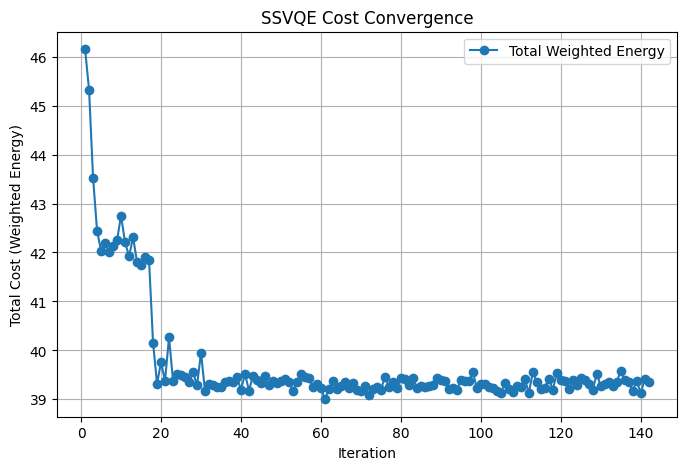

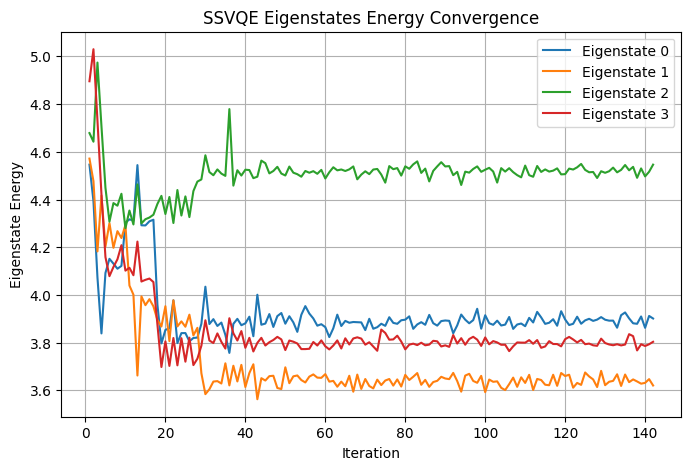

In [82]:

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 800, 1500, 150  # T2를 더 짧게

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear').decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.10, 1).compose(
    thermal_relaxation_error(1000, 2000, 150)
)
error_2q = depolarizing_error(0.12, 2)  # 20% → 12%로 줄임


noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 400}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()


[Iter 1] Cost: 44.857666
[Iter 2] Cost: 43.991211
[Iter 3] Cost: 42.966797
[Iter 4] Cost: 42.802246
[Iter 5] Cost: 42.406250
[Iter 6] Cost: 42.504395
[Iter 7] Cost: 42.701660
[Iter 8] Cost: 42.273682
[Iter 9] Cost: 42.252197
[Iter 10] Cost: 41.697754
[Iter 11] Cost: 41.337646
[Iter 12] Cost: 41.045654
[Iter 13] Cost: 41.315186
[Iter 14] Cost: 40.988770
[Iter 15] Cost: 40.980469
[Iter 16] Cost: 41.006348
[Iter 17] Cost: 40.976318
[Iter 18] Cost: 40.702393
[Iter 19] Cost: 40.934326
[Iter 20] Cost: 40.740967
[Iter 21] Cost: 41.223145
[Iter 22] Cost: 40.752930
[Iter 23] Cost: 40.366211
[Iter 24] Cost: 40.302002
[Iter 25] Cost: 40.406982
[Iter 26] Cost: 40.461670
[Iter 27] Cost: 40.559570
[Iter 28] Cost: 39.948486
[Iter 29] Cost: 40.434082
[Iter 30] Cost: 40.010986
[Iter 31] Cost: 40.192627
[Iter 32] Cost: 39.761230
[Iter 33] Cost: 39.861816
[Iter 34] Cost: 39.895996
[Iter 35] Cost: 39.613770
[Iter 36] Cost: 39.570068
[Iter 37] Cost: 39.671631
[Iter 38] Cost: 39.454590
[Iter 39] Cost: 39.33

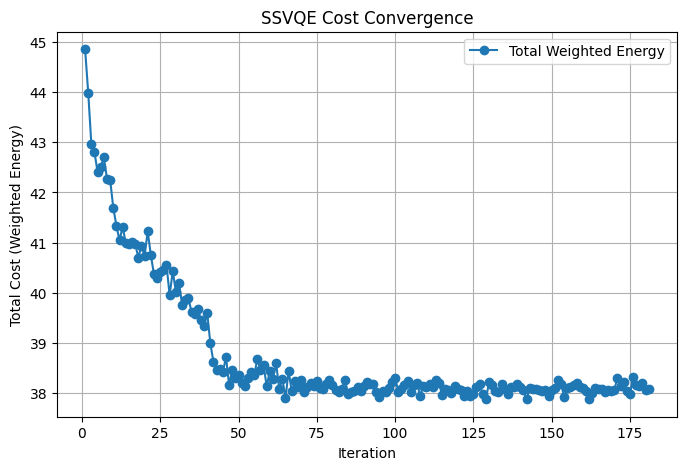

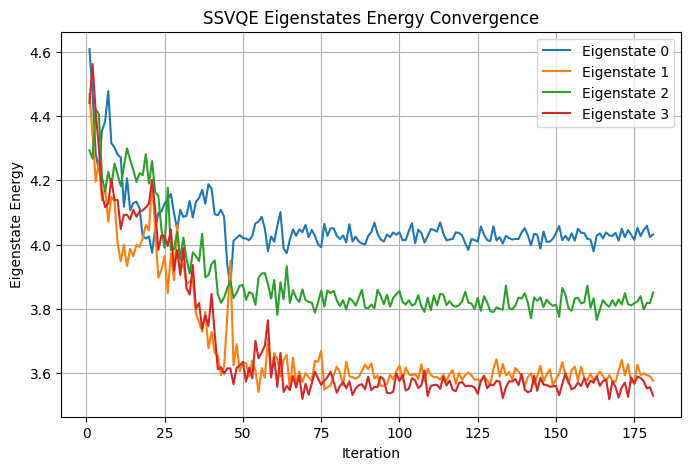

In [75]:


import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 800, 1500, 150  # T2를 더 짧게

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear').decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.15, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time)
)
error_2q = depolarizing_error(0.20, 2)  # 매우 강하게 설정


noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 400}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()



[Iter 1] Cost: 42.998535
[Iter 2] Cost: 42.414307
[Iter 3] Cost: 42.164307
[Iter 4] Cost: 42.061768
[Iter 5] Cost: 42.088867
[Iter 6] Cost: 41.981934
[Iter 7] Cost: 42.207520
[Iter 8] Cost: 41.868408
[Iter 9] Cost: 41.911133
[Iter 10] Cost: 41.725098
[Iter 11] Cost: 41.505615
[Iter 12] Cost: 41.250732
[Iter 13] Cost: 41.432617
[Iter 14] Cost: 41.253418
[Iter 15] Cost: 40.984619
[Iter 16] Cost: 41.141602
[Iter 17] Cost: 41.049561
[Iter 18] Cost: 40.891113
[Iter 19] Cost: 40.867676
[Iter 20] Cost: 40.660156
[Iter 21] Cost: 40.649902
[Iter 22] Cost: 40.636963
[Iter 23] Cost: 40.370850
[Iter 24] Cost: 40.353760
[Iter 25] Cost: 40.273193
[Iter 26] Cost: 40.217041
[Iter 27] Cost: 40.217285
[Iter 28] Cost: 40.276611
[Iter 29] Cost: 40.283936
[Iter 30] Cost: 40.361816
[Iter 31] Cost: 40.427002
[Iter 32] Cost: 40.448486
[Iter 33] Cost: 40.330322
[Iter 34] Cost: 40.263672
[Iter 35] Cost: 40.331299
[Iter 36] Cost: 40.059570
[Iter 37] Cost: 40.403320
[Iter 38] Cost: 40.722168
[Iter 39] Cost: 40.42

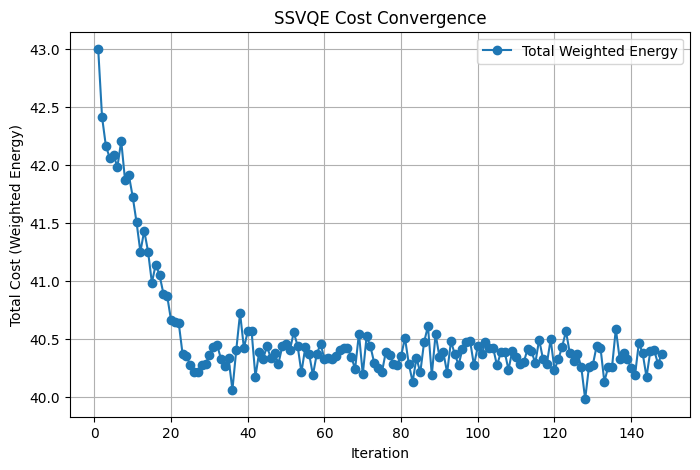

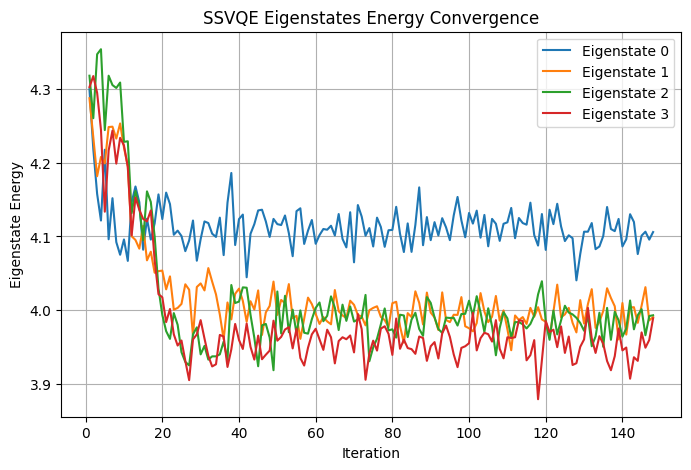

In [81]:


import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from scipy.optimize import minimize

# Parameters
num_qubits = 4
t1, t2, gate_time = 700, 1400, 150  # T2를 더 짧게

# Define initial states
initial_states = []
for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)
    initial_states.append(qc)

# Define Hamiltonian
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]
    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)

hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

# Ansatz
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear').decompose()
weights = np.arange(num_qubits, 0, -1)

# Noise Model
noise_model = NoiseModel()
# 게이트 노이즈 강화
error_1q = depolarizing_error(0.3, 1).compose(
    thermal_relaxation_error(t1, t2, gate_time)
)
error_2q = depolarizing_error(0.3, 2)  # 매우 강하게 설정


noise_model.add_all_qubit_quantum_error(error_1q, ['u3', 'rx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
noise_model.add_all_qubit_readout_error(readout_error)

# Cost history storage
cost_history_dict = {
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)]
}

# Expectation value calculator
def calculate_expectation(counts, pauli_op, shots=8192):
    expval = 0
    for bitstring, count in counts.items():
        value = 0
        for pauli_str, coeff in zip(pauli_op.paulis, pauli_op.coeffs):
            sign = 1
            for idx, p in enumerate(pauli_str.to_label()):
                if p == 'Z' and bitstring[::-1][idx] == '1':
                    sign *= -1
            value += coeff.real * sign
        expval += value * count / shots
    return expval

# Cost function with history tracking
def ssvqe_cost_func(params, ansatz, hamiltonian, initial_states, weights, noise_model):
    backend = AerSimulator(noise_model=noise_model)
    backend.set_options(shots=8192)
    energies = []

    for init_state in initial_states:
        circuit = init_state.compose(ansatz.assign_parameters(params))
        circuit.measure_all()
        transpiled = transpile(circuit, backend)
        result = backend.run(transpiled).result()
        counts = result.get_counts()
        energy = calculate_expectation(counts, hamiltonian)
        energies.append(energy)

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["total_energy"].append(weighted_energy)
    for i, e in enumerate(energies):
        cost_history_dict["eigenstates_energies"][i].append(e)

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")
    return weighted_energy

# Optimization
init_params = np.random.rand(ansatz.num_parameters)
result = minimize(
    ssvqe_cost_func,
    x0=init_params,
    args=(ansatz, hamiltonian, initial_states, weights, noise_model),
    method='COBYLA',
    options={'maxiter': 400}
)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, cost_history_dict["iters"] + 1), cost_history_dict["total_energy"], marker='o', label='Total Weighted Energy')
plt.xlabel("Iteration")
plt.ylabel("Total Cost (Weighted Energy)")
plt.title("SSVQE Cost Convergence")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i, energy_list in enumerate(cost_history_dict["eigenstates_energies"]):
    plt.plot(range(1, cost_history_dict["iters"] + 1), energy_list, marker='', label=f"Eigenstate {i}")
plt.xlabel("Iteration")
plt.ylabel("Eigenstate Energy")
plt.title("SSVQE Eigenstates Energy Convergence")
plt.grid(True)
plt.legend()
plt.show()

